# About notebook:
This notebook contains extracts from the work on the ACLED dataset for the midterm in STK-INF4000.




# Loading everything

## Loading standard python modules

In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

# Adding modules folder to sys.path:
import sys
sys.path.insert(0, '../modules')

### Auto-reloading external modules
Ensure that all code inside our modules are reloaded upon new call to 'import'. Included to enable more rapid testing.

For details, see:
http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython

In [2]:
%load_ext autoreload
%autoreload 2
print('Loaded')

Loaded


## Loading ACLED dataset
The ACLED dataset is the main dataset for our project. From the ACLED projects' web site (http://www.acleddata.com/):

    "ACLED (Armed Conflict Location & Event Data Project) is the most comprehensive public collection of political violence and protest data for developing states."

The dataset cointains more than 156.000 entries, from 1997 up until today. The ACLED dataset is updated with *realtime* data on a weekly basis. 

### Datasets module
The datasets.ACLED class (imported below) connects to the ACLED API to download the latest available data to a **mongodb** database on the local computer. If the database already exists, a query to the API for updates is made and database updated as required.

In [3]:
import datasets

In [4]:
acled = datasets.ACLED()
acled.mongodb_update_database()

2017-03-27 22:36:48.141839 Querying ACLED API (one dot is 500 rows) ..
2017-03-27 22:36:57.510972 1 pages retrieved from ACLED API.
2017-03-27 22:36:57.511093 Make DataFrame...
2017-03-27 22:36:57.533768 Apply str->datetime on event_date...
212 records inserted to mongodb, 213 lines in csv. (Investigate difference)


#### Loading database content into Pandas dataframe:

In [5]:
df_full = acled.mongodb_get_entire_database()

In [6]:
df_full.keys()

Index(['_id', 'actor1', 'actor2', 'admin1', 'admin2', 'admin3', 'ally_actor_1',
       'ally_actor_2', 'country', 'data_id', 'event_date', 'event_id_cnty',
       'event_id_no_cnty', 'event_type', 'fatalities', 'geo_precision', 'gwno',
       'inter1', 'inter2', 'interaction', 'latitude', 'location', 'longitude',
       'notes', 'source', 'time_precision', 'year'],
      dtype='object')

## Loading ESRI shapefile

For plotting, we're using ESRI shapefile vector geodata from [1] with **geopandas** and **Bokeh**. 

**References:**

1) http://www.naturalearthdata.com/features/
2) http://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip

**Instructions**: Download and unzip [2] and direct the variable 'link_ESRI_shp' to the directory of the .shp-file.

**Dependencies**: Following python libraries required: bokeh, shapely, geopandas. Clang (or equivalent) is also required for these (For Ubuntu linux use: 'sudo apt-get install libgeos-dev').

In [7]:
from ImportShapefile import ImportShapefile 
# Update the link to where you have stored the shapefiles:
link = '../data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp'

gpd_df_full = ImportShapefile(link).get_df()

# Mask on countries in Africa:
mask = gpd_df_full['continent']=='Africa'
gpd_df = gpd_df_full.loc[mask,:].reset_index(drop=True)

del gpd_df_full

### Creating 'area' column:
Adding column containing 'proportionate area' (*).

** *:** I don't know the unit of the resulting areas. Numbers are at least proportionate to the countries area...

In [8]:
gpd_df['area_p'] = gpd_df['geometry'].area

###  Drop all except a few columns:

In [9]:
gpd_df = gpd_df.loc[:, ('name','subregion','x', 'y','area_p', 'pop_est')]

## Loading Bokeh-geopandas plotting class

In [10]:
import BokehPlottingScripts as BPS

Loading BokehJS ...

In [12]:
# Example plot:
p = BPS.bokeh_plot_map(gpd_df, data='area_p', title='Africa - Colour proportionate with area')

## Another plot (test)

In [13]:
gpd_df['test'] = 0
ind = gpd_df.loc[:,'name']=='Dem. Rep. Congo'
gpd_df.loc[ind, 'test']=1
q = BPS.bokeh_plot_map(gpd_df, data='test', title='Africa - Colour proportionate with area')

# Exploring the ACLED dataset
For this project, we focus on analysis of one country. Let's list the countries with the most entries:

In [14]:
df_full['country'].value_counts().head()

Somalia                         23998
Democratic Republic of Congo    11770
Sudan                           11587
Nigeria                         11480
South Africa                    10301
Name: country, dtype: int64

In [15]:
#country_to_analyze = 'Somalia'
country_to_analyze = 'Democratic Republic of Congo'

# New dataframe, filtering on one country:
df = df_full.loc[df_full.loc[:,'country']==country_to_analyze].reset_index(drop=True)

print("The dataframe now contains", len(df), "entries.")

The dataframe now contains 11770 entries.


## Types of events
The dataset cointains the categorical column **event_type**, describing the different types of events in the dataset (e.g., 'riots/protests' and 'violence against civilians').

In [16]:
print(df['event_type'].value_counts())

Battle-No change of territory                 4052
Violence against civilians                    3640
Riots/Protests                                1437
Strategic development                         1019
Battle-Government regains territory            615
Battle-Non-state actor overtakes territory     465
Non-violent transfer of territory              290
Remote violence                                146
Headquarters or base established               104
Strategic Development                            2
Name: event_type, dtype: int64


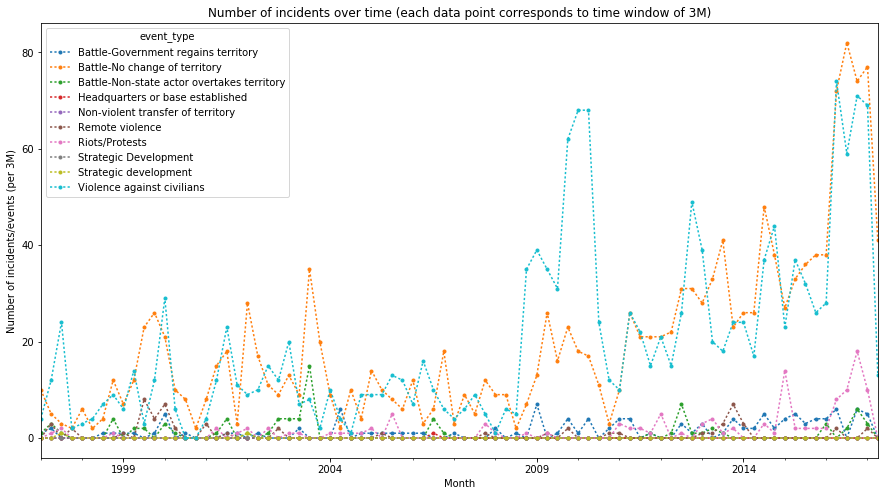

In [17]:
df_piv = df.pivot_table(index='event_date',
                              columns='event_type',
                              values='fatalities',
                              aggfunc=np.count_nonzero) # Aggregate count of events

df_piv = df_piv.fillna(0)
resample_freq = '3M'
df_piv = df_piv.resample(resample_freq).sum()

ax = df_piv.plot(marker='.', linestyle='dotted', figsize=(15,8))
ax.set_title("Number of incidents over time (each data point corresponds to time window of "+resample_freq+")")
ax.set_ylabel("Number of incidents/events (per "+resample_freq+")")
ax.set_xlabel("Month")


## Fatalities
Each datapoint also contains a column with an estaimate of the number of fatalities of the incident described.

Let's look at the data:

In [20]:
df_p_fat = df.pivot_table(index='event_date',
                              columns='event_type',
                              values='fatalities',
                              aggfunc=np.sum) # This time we add (instead of count)

stats = df_p_fat.describe().loc[['mean', 'std', 'max']]
# Adding total:
stats = stats.append(pd.Series(df_p_fat.sum(), name='sum', dtype='int'))
stats

event_type,Battle-Government regains territory,Battle-No change of territory,Battle-Non-state actor overtakes territory,Headquarters or base established,Non-violent transfer of territory,Remote violence,Riots/Protests,Strategic Development,Strategic development,Violence against civilians
mean,4.476309,9.716277,8.388554,0.054054,0.0,18.491379,0.738706,0.0,0.071046,22.356902
std,16.737535,47.623083,47.478692,0.464991,0.0,96.066145,4.435366,0.0,1.833775,550.281542
max,140.000000,1062.000000,800.000000,4.000000,0.0,835.000000,80.000000,0.0,50.000000,25000.000000
sum,1795.000000,23698.000000,2785.000000,4.000000,0.0,2145.000000,605.000000,0.0,53.000000,46480.000000


The dataset event also contains the column **fatalities**:

# Everything below here still in work:

## Outliers, if we want to...

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
mu, sd = df['fatalities'].describe()[1:3]
z_values = (df['fatalities']-mu)/sd
z_values.head(5)

0   -0.028406
1   -0.028406
2   -0.028406
3    0.079356
4   -0.028406
Name: fatalities, dtype: float64

(0, 1000)

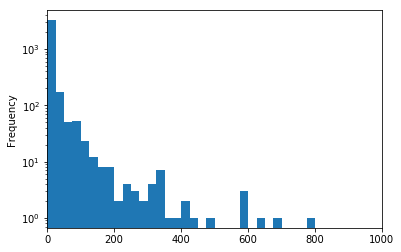

In [23]:

fat = df[df['fatalities']>=1]


fat['fatalities'].plot.hist(bins=1000)
plt.yscale('log')
plt.xlim(0,1000)

In [24]:
fat_zero = sum(df['fatalities']<1)
fat_nonzero = sum(df['fatalities']>=1)

print("No fat:", fat_zero, "Fat:", fat_nonzero, "Fraction:", fat_nonzero/(fat_nonzero+fat_zero))

No fat: 8163 Fat: 3607 Fraction: 0.306457094308


In [ ]:
df['fatalities'].describe()

In [ ]:

fat = df[df['fatalities']>=0]


fat['fatalities'].plot.hist(bins=100)
plt.yscale('log')
#plt.xlim(0,1000)

## Plotting some conflicts

In [ ]:
from shapely.geometry import Point

def apply_geo_points(df):
    return Point(df['latitude'], df['longitude'])

df['geo_point'] = df.apply(apply_geo_points, axis=1)

In [ ]:
df_remote_v = df.loc[:,]

In [ ]:
from geopandas import GeoSeries

geoseries = GeoSeries(df['geo_point'])
geoseries.crs = {'init': 'epsg:4326'}

In [ ]:
from bokeh.io import output_notebook, show


In [ ]:
#https://anaconda.org/debboutr/lightning/notebook
p.circle([df.latitude], [df.longitude], size=10)

In [ ]:
show(p)

In [ ]:
df['geo_point'].x

In [ ]:
df['latitude'][0]

In [ ]:

geoseries.plot(marker='.', color='red', markersize=12, figsize=(4, 4))
#plt.xlim([-123, -119.8])
#plt.ylim([44.8, 47.7]);

In [ ]:
df['geo_point'][0].plot(marker='*', color='green', markersize=5)

In [ ]:
pd.set_option('Max_columns',30)

In [ ]:
test = df.loc[df['fatalities']>1000]['notes']

In [ ]:
test.

In [ ]:
df['fatalities'].hist(bins=30)

In [ ]:
df.keys()

In [ ]:
print(df['actor2'].value_counts().head(15))